Name: Arya Sun
<br>
Github Username: fearofhelicopter
<br>
USC ID: 8111052837

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, auc, roc_curve, plot_roc_curve, RocCurveDisplay, confusion_matrix, classification_report 
from sklearn.naive_bayes import GaussianNB, MultinomialNB


import statsmodels.api as sm
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

Get the AReM Data Set

In [2]:
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
dfs = dict()
for folder in folders:
    path = os.path.join("../", "data", "AReM", folder)
    files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat([pd.read_csv(f, skiprows = 4) for f in files], ignore_index=True)
    dfs[folder] = df
#dfs

### (b) Splitting Data

In [3]:
traindata = []
testdata = []

for folder in os.listdir(os.path.join("../", "data", "AReM")):
    if folder in ["bendingType.pdf", "sensorsPlacement.pdf"]:
        continue
    else:
        for file in os.listdir(os.path.join("../", "data", "AReM", folder)):
            if folder in ["bending1", "bending2"] and file in ["dataset1.csv","dataset2.csv"]:
                testdata.append(os.path.join("../", "data", "AReM", folder, file))
            elif folder not in ["bending1", "bending2"] and file in ["dataset1.csv","dataset2.csv","dataset3.csv"]:
                testdata.append(os.path.join("../", "data", "AReM", folder, file))
            else:
                traindata.append(os.path.join("../", "data", "AReM", folder, file))
df_train = pd.concat([pd.read_csv(f, skiprows = 4) for f in traindata], ignore_index=True) 
df_test = pd.concat([pd.read_csv(f, skiprows = 4) for f in testdata], ignore_index=True)

#print(df_train)
#print(df_test)

In [4]:
trainLabel = []
for f in traindata:
    if "bending" in f:
        trainLabel.extend(["bending"] * pd.read_csv(f, skiprows = 4).shape[0])
    else:
        trainLabel.extend(["others"] * pd.read_csv(f, skiprows = 4).shape[0])

testLabel = []
for f in testdata:
    if "bending" in f:
        testLabel.extend(["bending"] * pd.read_csv(f, skiprows = 4).shape[0])
    else:
        testLabel.extend(["others"] * pd.read_csv(f, skiprows = 4).shape[0])

### (c) Feature Extraction

In [5]:
rowList = []
for file in traindata:
    dfT = pd.read_csv(file, skiprows = 4)
    df1 = dfT.describe().T
    df1 = df1[["min","max", "mean", "std", "50%", "25%", "75%"]]
    df1 = df1[1:]
    row = df1.values.reshape(1, -1)
    row = pd.DataFrame(row)
    rowList.append(row)
dfFeatureTrain = pd.concat(rowList)

rowList = []
for file in testdata:
    dfT = pd.read_csv(file, skiprows = 4)
    df1 = dfT.describe().T
    df1 = df1[["min","max", "mean", "std","50%", "25%", "75%"]]
    df1 = df1[1:]
    row = df1.values.reshape(1, -1)
    row = pd.DataFrame(row)
    rowList.append(row)
dfFeatureTest = pd.concat(rowList)

dfFeature = pd.concat([dfFeatureTrain, dfFeatureTest], ignore_index=True)
dfFeature.columns = ["min1","max1", "mean1", "std1", "50%1", "25%1", "75%1",
                     "min2","max2", "mean2", "std2", "50%2", "25%2", "75%2",
                     "min3","max3", "mean3", "std3", "50%3", "25%3", "75%3",
                     "min4","max4", "mean4", "std4", "50%4", "25%4", "75%4",
                     "min5","max5", "mean5", "std5", "50%5", "25%5", "75%5",
                     "min6","max6", "mean6", "std6", "50%6", "25%6", "75%6"]

dfFeature.index = np.arange(1, len(dfFeature) + 1)
dfFeature.index.name = 'Instance'

dfFeature

min1   max1      mean1      std1    50%1   25%1     75%1  min2  \
Instance                                                                    
1         36.25  48.00  43.969125  1.618364  44.500  43.31  44.6700   0.0   
2         37.00  48.00  43.454958  1.386098  43.250  42.50  45.0000   0.0   
3         33.00  47.75  42.179813  3.670666  43.500  39.15  45.0000   0.0   
4         33.00  45.75  41.678063  2.243490  41.750  41.33  42.7500   0.0   
5         35.00  47.40  43.954500  1.558835  44.330  43.00  45.0000   0.0   
...         ...    ...        ...       ...     ...    ...      ...   ...   
84        24.75  48.33  44.182937  7.495615  48.000  48.00  48.0000   0.0   
85        48.00  48.25  48.004167  0.032038  48.000  48.00  48.0000   0.0   
86        24.25  45.00  37.177042  3.581301  36.250  34.50  40.2500   0.0   
87        28.75  44.75  37.561188  3.226507  36.875  35.25  40.2500   0.0   
88        22.00  44.67  37.058708  3.710180  36.000  34.50  40.0625   0.0   

           max2     mean2  ...    50%5     25%5     75%5  min6  max6  \
Instance                   ...                                         
1          1.50  0.413125  ...  21.670  20.5000  23.7500   0.0  2.96   
2          1.58  0.378083  ...  23.500  22.2500  24.0000   0.0  5.26   
3          3.00  0.696042  ...  35.000  30.4575  36.3300   0.0  2.18   
4          2.83  0.535979  ...  30.000  28.4575  31.2500   0.0  1.79   
5          1.70  0.426250  ...  36.000  35.3625  36.5000   0.0  1.79   
...         ...       ...  ...     ...      ...      ...   ...   ...   
84         3.11  0.101875  ...   3.330   2.0000   5.5425   0.0  3.91   
85         0.43  0.007167  ...   9.000   4.6700  10.0000   0.0  2.50   
86         8.58  2.374208  ...  20.000  17.9500  21.7500   0.0  9.34   
87         9.91  2.080688  ...  20.000  18.0000  21.5000   0.0  9.62   
88        14.17  2.438146  ...  18.875  16.0000  21.0000   0.0  8.55   

             mean6      std6  50%6    25%6  75%6  
Instance                                          
1         0.555313  0.487826  0.49  0.0000  0.83  
2         0.679646  0.622534  0.50  0.4300  0.87  
3         0.613521  0.524317  0.50  0.0000  1.00  
4         0.383292  0.389164  0.43  0.0000  0.50  
5         0.493292  0.513506  0.43  0.0000  0.94  
...            ...       ...   ...     ...   ...  
84        0.692771  0.675781  0.50  0.3225  0.94  
85        0.641229  0.388372  0.50  0.4600  0.83  
86        2.921729  1.852600  2.50  1.5000  3.90  
87        2.765896  1.769203  2.45  1.4100  3.77  
88        2.983750  1.815730  2.57  1.5000  4.15  

[88 rows x 42 columns]

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots
Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

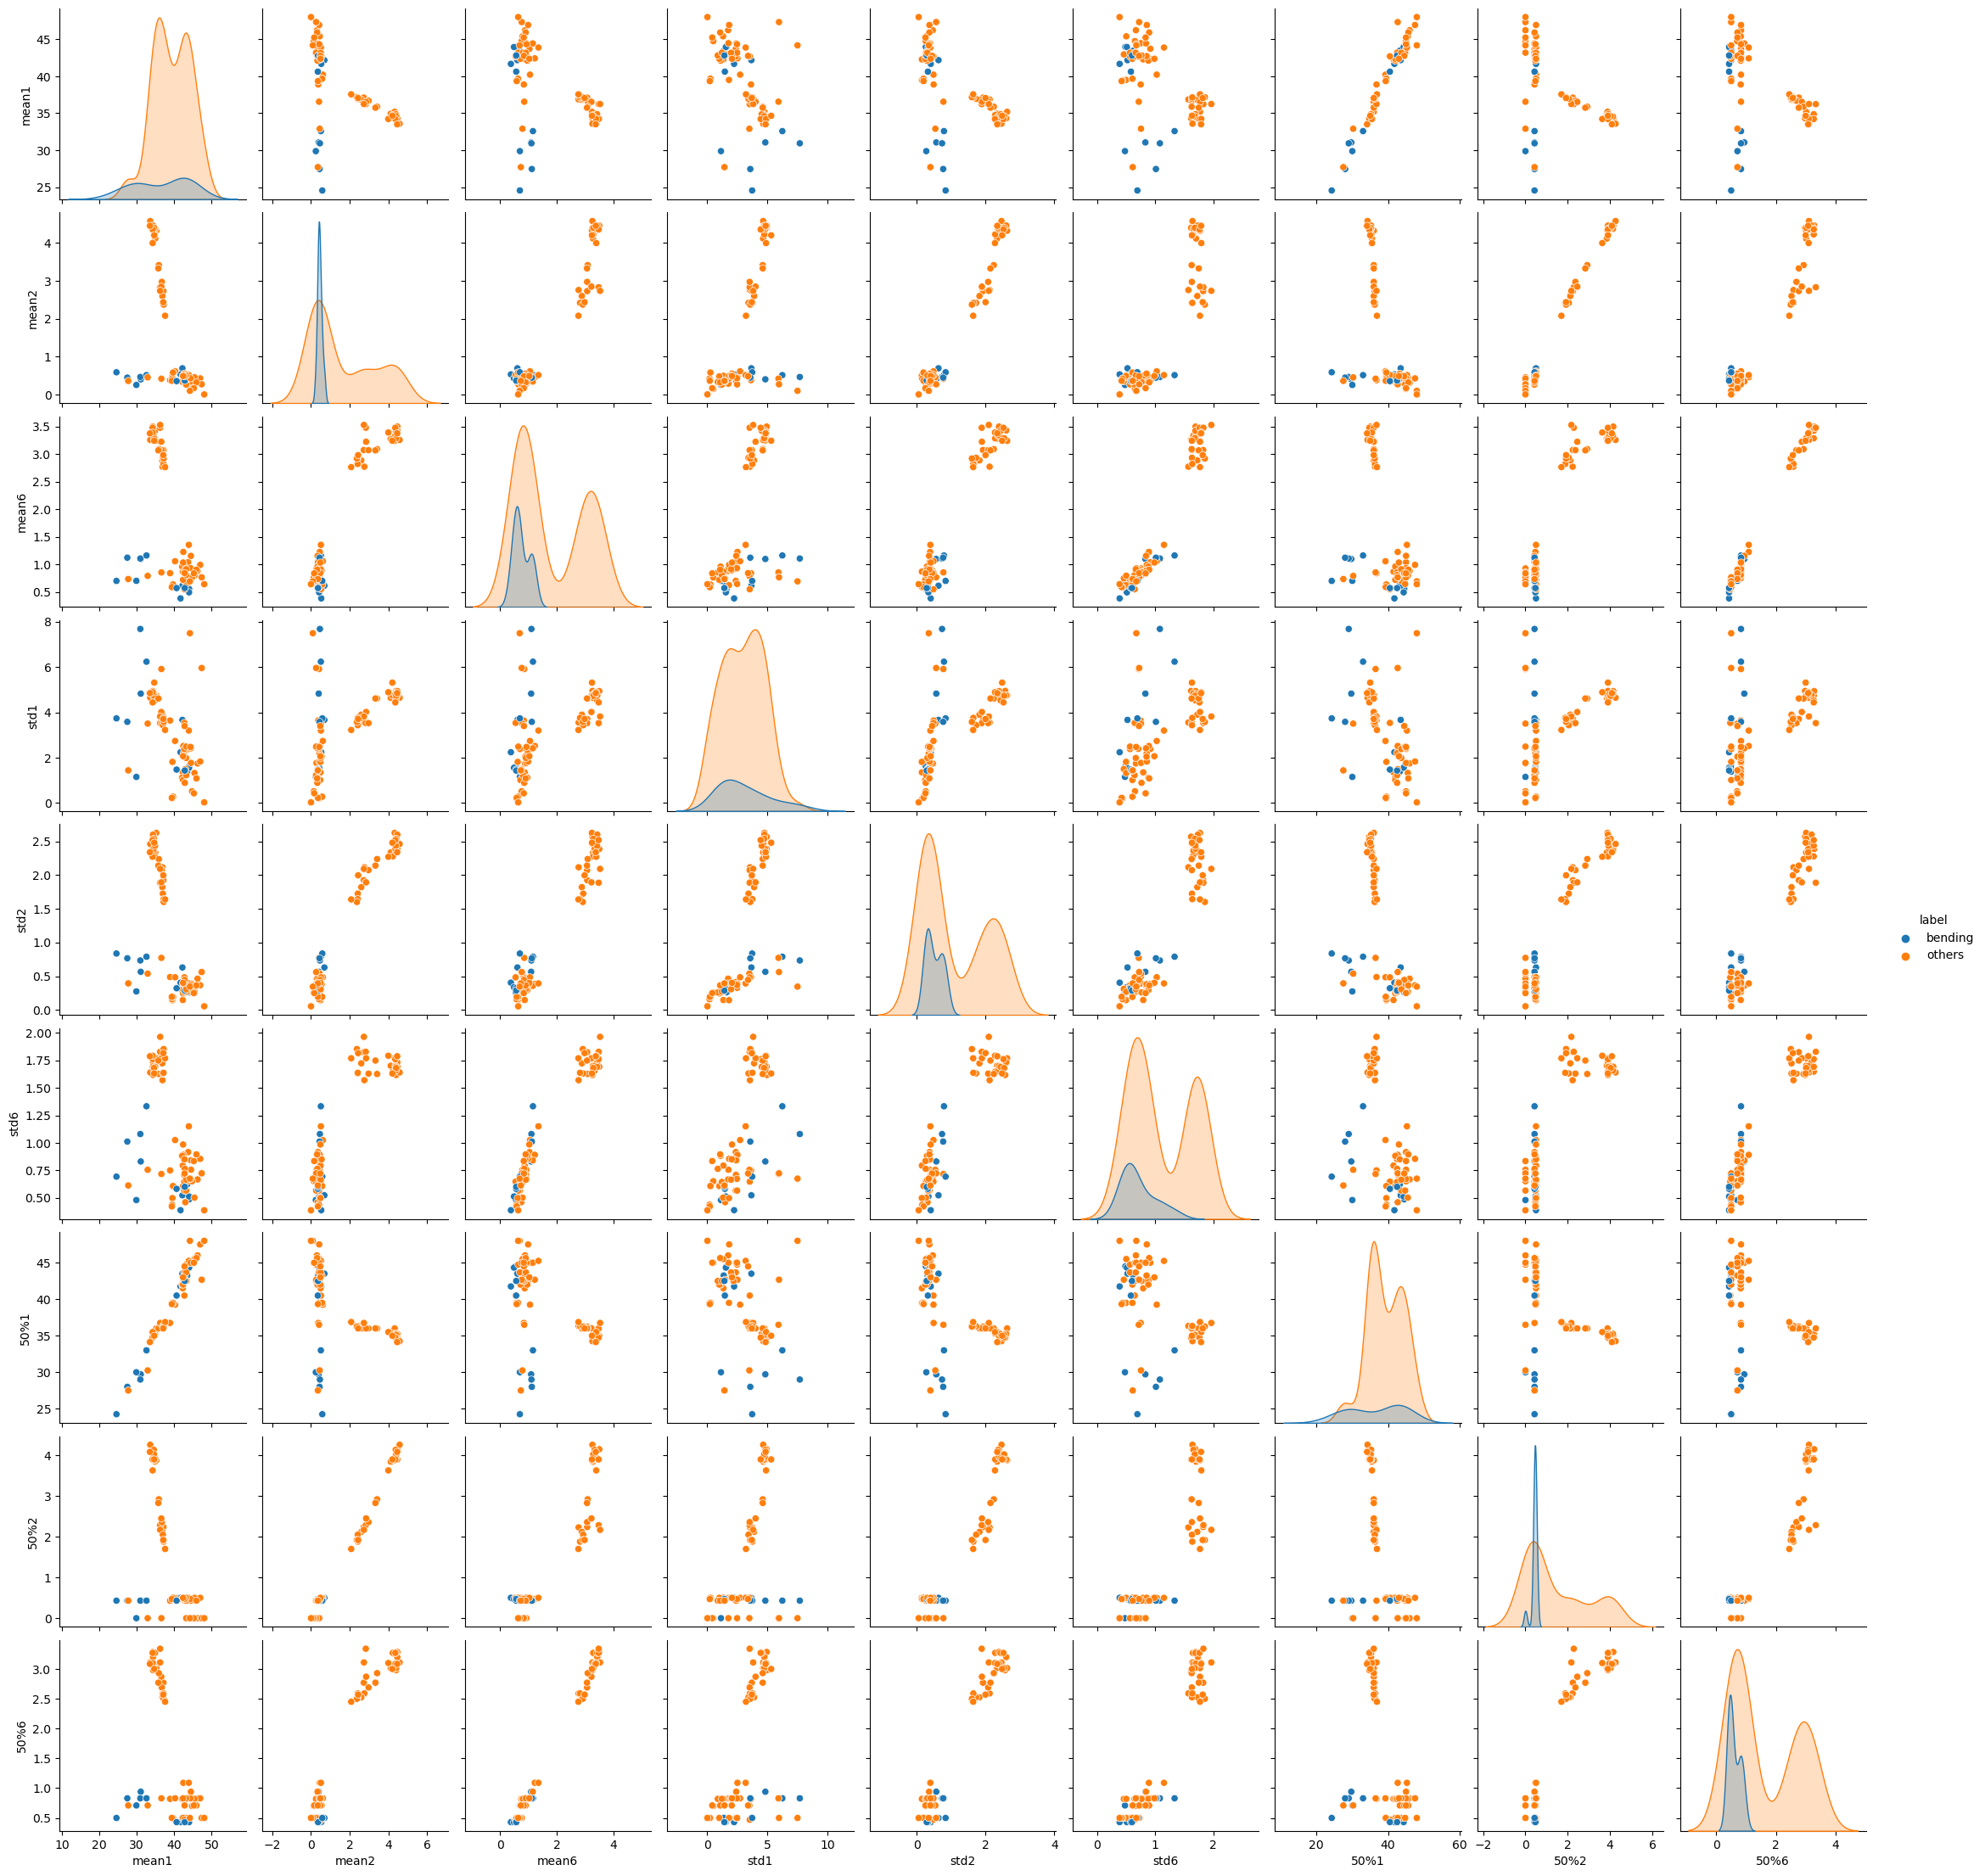

In [6]:
dfFeatureSelect = dfFeature.loc[:, ["mean1", "mean2", "mean6", "std1", "std2", "std6", "50%1", "50%2", "50%6"]]

fileLabel = ["bending" if "bending" in f else "others" for f in traindata + testdata]
dfFeatureSelect.loc[:, "label"] = fileLabel

sns.pairplot(data = dfFeatureSelect, hue = "label")
plt.show()

#### ii. Splitted Plots
Break each time series in your training set into two (approximately) equallength time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 4(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 4(a)i?

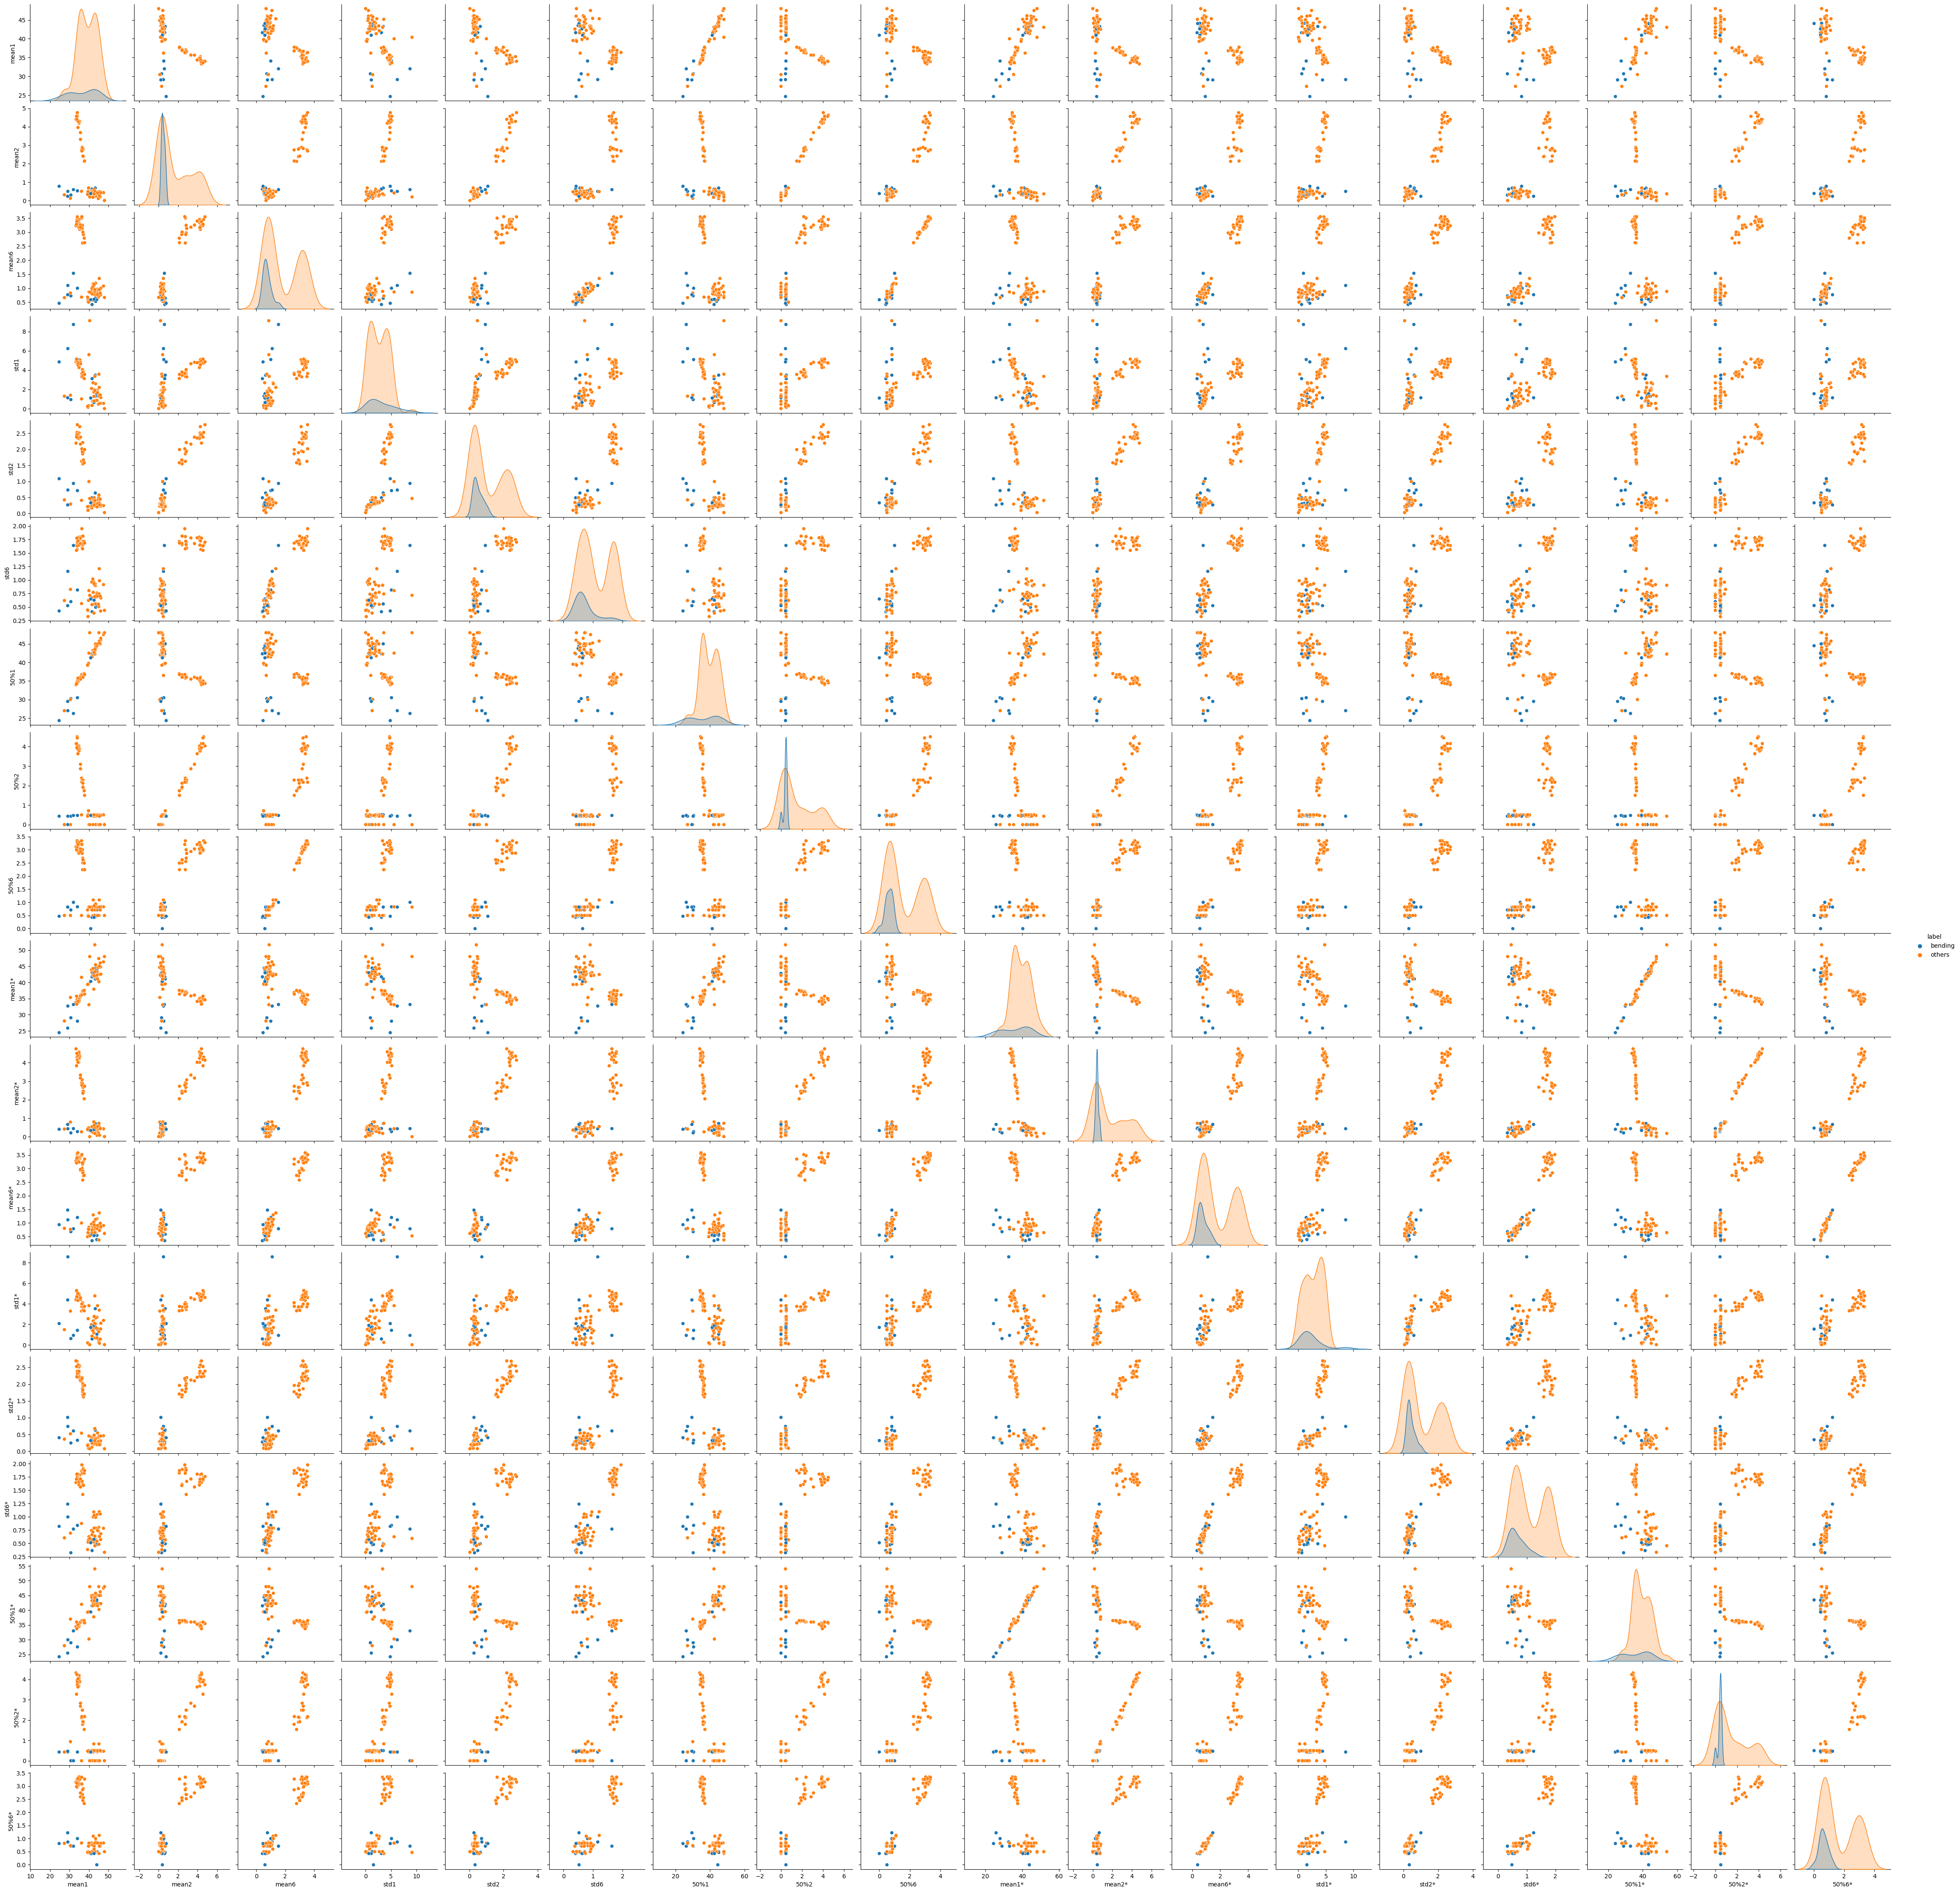

In [7]:
rowList = []
for file in traindata:
    dfT = pd.read_csv(file, skiprows = 4)
    halfNum = dfT.shape[0]//2
    halfList = []
    for i in range(0,2):
        dfTHalf = dfT.loc[halfNum * i : halfNum * (i + 1),]
        df1 = dfTHalf.describe().T
        df1 = df1[["min","max", "mean", "std", "50%", "25%", "75%"]]
        df1 = df1[1:]
        row = df1.values.reshape(1, -1)
        row = pd.DataFrame(row)
        halfList.append(row)
    rowNew = pd.concat(halfList, axis = 1)
    rowList.append(rowNew)
dfFeatureTrainNew = pd.concat(rowList)

rowList = []
for file in testdata:
    dfT = pd.read_csv(file, skiprows = 4)
    halfNum = dfT.shape[0] // 2
    halfList = []
    for i in range(0, 2):
        dfTHalf = dfT.loc[halfNum * i: halfNum * (i + 1), ]
        df1 = dfTHalf.describe().T
        df1 = df1[["min", "max", "mean", "std", "50%", "25%", "75%"]]
        df1 = df1[1:]
        row = df1.values.reshape(1, -1)
        row = pd.DataFrame(row)
        halfList.append(row)
    rowNew = pd.concat(halfList, axis = 1)
    rowList.append(rowNew)
dfFeatureTestNew = pd.concat(rowList)

dfFeatureNew = pd.concat([dfFeatureTrainNew, dfFeatureTestNew], ignore_index=True)
colNew = ["min1","max1", "mean1", "std1", "50%1", "25%1", "75%1",
          "min2","max2", "mean2", "std2", "50%2", "25%2", "75%2",
                     "min3","max3", "mean3", "std3", "50%3", "25%3", "75%3",
                     "min4","max4", "mean4", "std4", "50%4", "25%4", "75%4",
                     "min5","max5", "mean5", "std5", "50%5", "25%5", "75%5",
                     "min6","max6", "mean6", "std6", "50%6", "25%6", "75%6"]

dfFeatureNew.columns = colNew + [col + "*" for col in colNew]

dfFeatureNew.index = np.arange(1, len(dfFeatureNew) + 1)
dfFeatureNew.index.name = 'Instance'

dfFeatureSelect = dfFeatureNew.loc[:, ["mean1", "mean2", "mean6","std1","std2","std6","50%1","50%2","50%6",
                             "mean1*", "mean2*", "mean6*","std1*","std2*","std6*","50%1*","50%2*","50%6*"]]

fileLabel = ["bending" if "bending" in f else "others" for f in traindata + testdata]
dfFeatureSelect.loc[:,["label"] ] = fileLabel

sns.pairplot(data = dfFeatureSelect, hue = "label")
plt.show()

In [8]:
def getLSplitFeature(l):
    rowList = []
    for file in traindata:
        dfT = pd.read_csv(file, skiprows = 4)
        halfNum = dfT.shape[0]//l
        halfList = []
        for i in range(0,l):
            dfTHalf = dfT.loc[halfNum * i : halfNum * (i + 1),]
            df1 = dfTHalf.describe().T
            df1 = df1[["min","max", "mean", "std", "50%", "25%", "75%"]]
            df1 = df1[1:]
            row = df1.values.reshape(1, -1)
            row = pd.DataFrame(row)
            halfList.append(row)
        rowNew = pd.concat(halfList, axis = 1)
        rowList.append(rowNew)
    dfFeatureTrainNew = pd.concat(rowList)

    rowList = []
    for file in testdata:
        dfT = pd.read_csv(file, skiprows = 4)
        halfNum = dfT.shape[0] // l
        halfList = []
        for i in range(0, l):
            dfTHalf = dfT.loc[halfNum * i: halfNum * (i + 1), ]
            df1 = dfTHalf.describe().T
            df1 = df1[["min", "max", "mean", "std", "50%", "25%", "75%"]]
            df1 = df1[1:]
            row = df1.values.reshape(1, -1)
            row = pd.DataFrame(row)
            halfList.append(row)
        rowNew = pd.concat(halfList, axis = 1)
        rowList.append(rowNew)
    dfFeatureTestNew = pd.concat(rowList)

    dfFeatureNew = pd.concat([dfFeatureTrainNew, dfFeatureTestNew], ignore_index = True)
    
    colBase = ["min", "max", "mean", "std", "50%", "25%", "75%"]

    colList = []
    for i in range(1, l * 6 + 1):
        for c in colBase:
            colList.append(c + "_{}".format(i))

    dfFeatureNew.columns = colList

    dfFeatureNew.index = np.arange(1, len(dfFeatureNew) + 1)
    dfFeatureNew.index.name = 'Instance'
    
    return dfFeatureNew

In [9]:
# dfFeatureSelect = getLSplitFeature(l = 2)

# fileLabel = ["bending" if "bending" in f else "others" for f in traindata + testdata]
# dfFeatureSelect.loc[:, ["label"] ] = fileLabel

# sns.pairplot(data = dfFeatureSelect, hue = "label")
# plt.show()

No considerable but a little difference can be seen in the results since bending vs. other activities are linearly separable using two extracted features. The separation and visualization effect of the scatter plot is more apparent when breaking each time series in the training set into two equal-length time series.

#### iii. Time Series Segments
Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

In [10]:
def featureToXY(dfFeatureSelect):
    dfFeatureSelectTrain = dfFeatureSelect.iloc[0:69, ].reset_index(drop = True)
    trainLabel = ["bending" if "bending" in f else "others" for f in traindata]
    YTrain = pd.DataFrame({"label": trainLabel}).reset_index(drop = True)

    dfFeatureSelectTest = dfFeatureSelect.iloc[69:, ].reset_index(drop = True)
    testLabel = ["bending" if "bending" in f else "others" for f in testdata]
    YTest = pd.DataFrame({"label": testLabel}).reset_index(drop = True)

    return dfFeatureSelectTrain, YTrain, dfFeatureSelectTest, YTest

In [11]:
resultDict = {}
totalAccList = []

for l in tqdm(range(1, 21)):
    dfFeatureSelect = getLSplitFeature(l)

    dfFeatureSelectTrain, YTrain, dfFeatureSelectTest, YTest = featureToXY(dfFeatureSelect)

    #build logistic regression
    lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)

    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

    lst_accu_stratified = []
    n_features_list = []
    best_support_list = []

    for train_index, test_index in skf.split(dfFeatureSelectTrain, YTrain):
        x_train_fold, x_test_fold = dfFeatureSelectTrain.loc[train_index], dfFeatureSelectTrain.loc[test_index]
        y_train_fold, y_test_fold = YTrain.loc[train_index], YTrain.loc[test_index]

        rfe = RFE(lr)
        rfe = rfe.fit(x_train_fold, y_train_fold.values.ravel())
        lst_accu_stratified.append(rfe.score(x_test_fold, y_test_fold))
        n_features_list.append(rfe.n_features_)
        best_support_list.append(rfe.support_)
    
    print("===={}====".format(l))
    print('List of possible accuracy:', lst_accu_stratified)
    print('\nOverall Accuracy:', np.mean(lst_accu_stratified) * 100, '%')

    best_p = n_features_list[lst_accu_stratified.index(max(lst_accu_stratified))]
    print("best p: {}, accuracy: {}".format(best_p, max(lst_accu_stratified)))

    resultDict[l] = {"accuracy": np.mean(lst_accu_stratified),
                     "best_p": best_p,
                     "support": best_support_list[np.argmax(lst_accu_stratified)]}

    totalAccList.append(np.mean(lst_accu_stratified))


bestAccIdx = np.argmax(totalAccList)

print('==========')
print("best l: {}, best p: {}, best accuracy: {:%}".format(bestAccIdx + 1, resultDict[bestAccIdx + 1]["best_p"], resultDict[bestAccIdx + 1]["accuracy"]))

  5%|██▏                                         | 1/20 [00:01<00:29,  1.58s/it]

====1====
List of possible accuracy: [1.0, 1.0, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 98.57142857142858 %
best p: 21, accuracy: 1.0


 10%|████▍                                       | 2/20 [00:04<00:46,  2.56s/it]

====2====
List of possible accuracy: [0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 42, accuracy: 1.0


 15%|██████▌                                     | 3/20 [00:09<01:01,  3.61s/it]

====3====
List of possible accuracy: [0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 63, accuracy: 1.0


 20%|████████▊                                   | 4/20 [00:16<01:18,  4.90s/it]

====4====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0]

Overall Accuracy: 95.71428571428571 %
best p: 84, accuracy: 1.0


 25%|███████████                                 | 5/20 [00:25<01:35,  6.34s/it]

====5====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 105, accuracy: 1.0


 30%|█████████████▏                              | 6/20 [00:36<01:50,  7.91s/it]

====6====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0]

Overall Accuracy: 95.71428571428571 %
best p: 126, accuracy: 1.0


 35%|███████████████▍                            | 7/20 [00:51<02:11, 10.10s/it]

====7====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 147, accuracy: 1.0


 40%|█████████████████▌                          | 8/20 [01:07<02:27, 12.25s/it]

====8====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 168, accuracy: 1.0


 45%|███████████████████▊                        | 9/20 [01:29<02:46, 15.11s/it]

====9====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9230769230769231]

Overall Accuracy: 92.74725274725274 %
best p: 189, accuracy: 1.0


 50%|█████████████████████▌                     | 10/20 [01:55<03:03, 18.40s/it]

====10====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 210, accuracy: 1.0


 55%|███████████████████████▋                   | 11/20 [02:19<03:03, 20.35s/it]

====11====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 231, accuracy: 1.0


 60%|█████████████████████████▊                 | 12/20 [02:44<02:53, 21.74s/it]

====12====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 252, accuracy: 1.0


 65%|███████████████████████████▉               | 13/20 [03:17<02:55, 25.03s/it]

====13====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 273, accuracy: 1.0


 70%|██████████████████████████████             | 14/20 [03:51<02:46, 27.74s/it]

====14====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9230769230769231]

Overall Accuracy: 92.74725274725274 %
best p: 294, accuracy: 1.0


 75%|████████████████████████████████▎          | 15/20 [04:27<02:30, 30.19s/it]

====15====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9230769230769231]

Overall Accuracy: 92.74725274725274 %
best p: 315, accuracy: 1.0


 80%|██████████████████████████████████▍        | 16/20 [05:02<02:06, 31.67s/it]

====16====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9230769230769231]

Overall Accuracy: 92.74725274725274 %
best p: 336, accuracy: 1.0


 85%|████████████████████████████████████▌      | 17/20 [05:44<01:44, 34.71s/it]

====17====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]

Overall Accuracy: 94.28571428571428 %
best p: 357, accuracy: 1.0


 90%|██████████████████████████████████████▋    | 18/20 [06:27<01:14, 37.30s/it]

====18====
List of possible accuracy: [0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 0.9230769230769231]

Overall Accuracy: 94.17582417582418 %
best p: 378, accuracy: 1.0


 95%|████████████████████████████████████████▊  | 19/20 [07:13<00:39, 39.84s/it]

====19====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9230769230769231]

Overall Accuracy: 92.74725274725274 %
best p: 399, accuracy: 1.0


100%|███████████████████████████████████████████| 20/20 [07:59<00:00, 24.00s/it]

====20====
List of possible accuracy: [0.8571428571428571, 0.9285714285714286, 0.9285714285714286, 1.0, 0.9230769230769231]

Overall Accuracy: 92.74725274725274 %
best p: 420, accuracy: 1.0
best l: 1, best p: 21, best accuracy: 98.571429%


The right way is to include feature selection in cross-validation.

The wrong way would be select features before cross-validation.

#### iv. Confusion Matrix
Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [12]:
dfFeatureL = getLSplitFeature(l = 1)
featureIdx = resultDict[1]["support"]
dfFeatureL = dfFeatureL[dfFeatureL.columns[featureIdx]]

dfFeatureLTrain, YLTrain, dfFeatureLTest, YLTest = featureToXY(dfFeatureL)

Y_train = YLTrain['label'].apply(lambda x: 1 if x == "bending" else 0)
Y_test = YLTest['label'].apply(lambda x: 1 if x == "bending" else 0)

lrModel = sm.Logit(Y_train, dfFeatureLTrain)
sm_model = lrModel.fit(method = 'lbfgs', maxiter = 1000, disp = False)
#print(sm_model.pvalues)
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                           20
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                   1.000
Time:                        15:11:02   Log-Likelihood:            -0.00011947
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 7.012e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mean_1        -0.9823   3.41e+05  -2.88e-06      1.000   -6.69e+05    6.69e+05
75%_1         -1.4703   3.73e+05  -3.94e-06      1.000   -7.31e+05    7.31e+05
max_2         -1.0255   9.42e+04  -1.09e-05      1.000   -1.85e+05    1.85e+05
mean_2        -0.4092    1.2e+06  -3.42e-07      1.000   -2.35e+06    2.35e+06
75%_2         -0.6303   1.02e+06  -6.17e-07      1.000      -2e+06       2e+06
min_3         -0.4666   9.92e+04   -4.7e-06      1.000   -1.94e+05    1.94e+05
max_3          0.6015   2.63e+05   2.28e-06      1.000   -5.16e+05    5.16e+05
mean_3        -0.3465    2.2e+06  -1.57e-07      1.000   -4.32e+06    4.32e+06
50%_3         -0.6137   3.15e+05  -1.95e-06      1.000   -6.17e+05    6.17e+05
25%_3         -0.1097   1.23e+06  -8.92e-08      1.000   -2.41e+06    2.41e+06
75%_3         -0.5498   7.39e+05  -7.44e-07      1.000   -1.45e+06    1.45e+06
max_4          0.0325   2.29e+05   1.42e-07      1.000   -4.49e+05    4.49e+05
mean_4        -0.3531   1.15e+06  -3.07e-07      1.000   -2.26e+06    2.26e+06
75%_4         -0.4656   1.69e+06  -2.76e-07      1.000   -3.31e+06    3.31e+06
min_5          1.2895   4.91e+04   2.63e-05      1.000   -9.63e+04    9.63e+04
max_5          2.1732   1.46e+05   1.49e-05      1.000   -2.86e+05    2.86e+05
mean_5         0.7761   7.67e+05   1.01e-06      1.000    -1.5e+06     1.5e+06
50%_5          0.4034   1.47e+06   2.75e-07      1.000   -2.88e+06    2.88e+06
25%_5          0.8160   1.04e+06   7.84e-07      1.000   -2.04e+06    2.04e+06
75%_5          0.4017   4.27e+05   9.41e-07      1.000   -8.37e+05    8.37e+05
75%_6         -0.5123   5.45e+05   -9.4e-07      1.000   -1.07e+06    1.07e+06
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

ROC_AUC:  1.0
AUC:  1.0
the confusion matrix:
 [[60  0]
 [ 0  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00         9

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



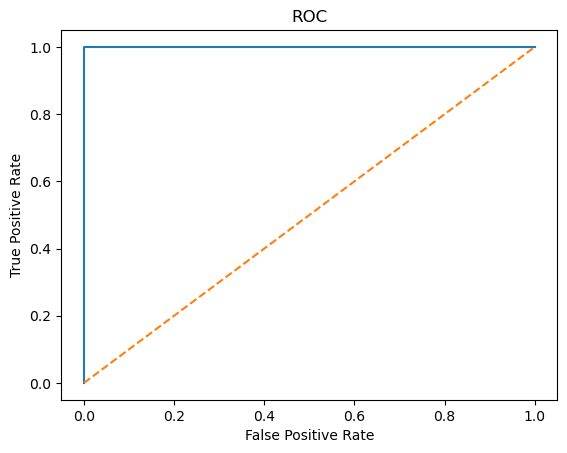

In [13]:
#prediction#
yPredTrain = sm_model.predict(dfFeatureLTrain)
yPredTrain = yPredTrain.apply(lambda x: 1 if x > 0.5 else 0)

roc_auc = roc_auc_score(Y_train, yPredTrain)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(Y_train, yPredTrain)
print("AUC: ", auc(fpr, tpr))

print('the confusion matrix:\n', confusion_matrix(Y_train, yPredTrain))

print(classification_report(Y_train, yPredTrain))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

#### v. Test Classifier
Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [14]:
yPredTest = sm_model.predict(dfFeatureLTest)
yPredTest = yPredTest.apply(lambda x: 1 if x > 0.5 else 0)

print("test accuracy: {}".format(accuracy_score(Y_test, yPredTest)))

test accuracy: 1.0


the accuracy on the test set is higher than the cross-validation accuracy 98.571429%

#### vi. Separation
Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes, the classes seem to be well-separated to cause instability in calculating logistic regression parameters.

#### vii. Imbalance

In [15]:
oversample = SMOTE()
dfFeatureLTrainS, Y_trainS = oversample.fit_resample(dfFeatureLTrain, Y_train)

lrModelS = sm.Logit(Y_trainS, dfFeatureLTrainS)
sm_modelS = lrModelS.fit(method = 'lbfgs', maxiter = 1000, disp = False)
#print(sm_modelS.pvalues)
sm_modelS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                  120
Model:                          Logit   Df Residuals:                       99
Method:                           MLE   Df Model:                           20
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                   1.000
Time:                        15:11:03   Log-Likelihood:            -0.00011896
converged:                       True   LL-Null:                       -83.178
Covariance Type:            nonrobust   LLR p-value:                 4.424e-25
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mean_1        -1.0501   8.26e+04  -1.27e-05      1.000   -1.62e+05    1.62e+05
75%_1         -1.4959   9.62e+04  -1.56e-05      1.000   -1.89e+05    1.89e+05
max_2         -0.7961   3.02e+04  -2.63e-05      1.000   -5.92e+04    5.92e+04
mean_2        -0.3433   4.73e+05  -7.26e-07      1.000   -9.26e+05    9.26e+05
75%_2         -0.5317   4.39e+05  -1.21e-06      1.000   -8.61e+05    8.61e+05
min_3         -0.4390   6.29e+04  -6.97e-06      1.000   -1.23e+05    1.23e+05
max_3          0.4529   7.52e+04   6.03e-06      1.000   -1.47e+05    1.47e+05
mean_3        -0.3449   7.43e+05  -4.64e-07      1.000   -1.46e+06    1.46e+06
50%_3         -0.5930    1.6e+05  -3.71e-06      1.000   -3.14e+05    3.14e+05
25%_3         -0.1344   4.26e+05  -3.15e-07      1.000   -8.36e+05    8.36e+05
75%_3         -0.5347   2.28e+05  -2.35e-06      1.000   -4.47e+05    4.47e+05
max_4         -0.0155   8.38e+04  -1.85e-07      1.000   -1.64e+05    1.64e+05
mean_4        -0.2878   1.04e+06  -2.76e-07      1.000   -2.04e+06    2.04e+06
75%_4         -0.3751   7.74e+05  -4.85e-07      1.000   -1.52e+06    1.52e+06
min_5          1.5640   2.07e+04   7.56e-05      1.000   -4.05e+04    4.05e+04
max_5          2.1170   2.33e+04    9.1e-05      1.000   -4.56e+04    4.56e+04
mean_5         0.8261   3.64e+05   2.27e-06      1.000   -7.13e+05    7.13e+05
50%_5          0.5072      5e+05   1.01e-06      1.000   -9.79e+05    9.79e+05
25%_5          0.7982   2.19e+05   3.65e-06      1.000   -4.29e+05    4.29e+05
75%_5          0.5476   8.98e+04    6.1e-06      1.000   -1.76e+05    1.76e+05
75%_6         -0.4379   2.45e+05  -1.79e-06      1.000   -4.81e+05    4.81e+05
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

test accuracy: 1.0
ROC_AUC:  1.0
AUC:  1.0
the confusion matrix:
 [[15  0]
 [ 0  4]]


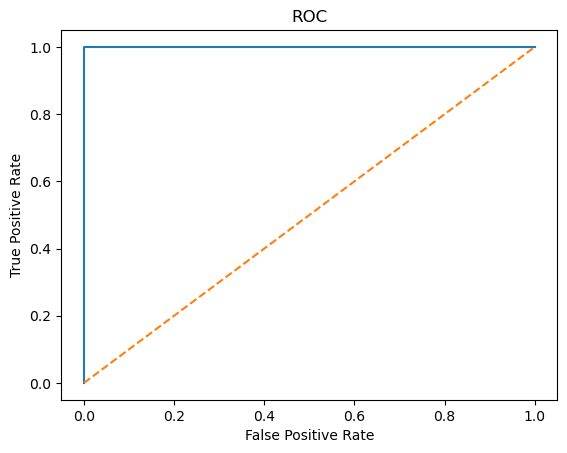

In [16]:
yPredTestS = sm_modelS.predict(dfFeatureLTest)
yPredTestS = yPredTestS.apply(lambda x: 1 if x > 0.5 else 0)

print("test accuracy: {}".format(accuracy_score(Y_test, yPredTestS)))

roc_auc = roc_auc_score(Y_test, yPredTestS)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(Y_test, yPredTestS)
print("AUC: ", auc(fpr, tpr))

print('the confusion matrix:\n', confusion_matrix(Y_test, yPredTestS))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments
Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [17]:
resultDict = {}
for l in tqdm(range(1, 21)):
    dfFeatureSelect = getLSplitFeature(l)

    dfFeatureSelectTrain, YTrain, dfFeatureSelectTest, YTest = featureToXY(dfFeatureSelect)
    
    stdNorm = preprocessing.MinMaxScaler()
    dfFeatureSelectTrain = stdNorm.fit_transform(dfFeatureSelectTrain)
    dfFeatureSelectTest = stdNorm.transform(dfFeatureSelectTest)
    
    for C in [1, 5, 10, 50, 100, 1000]:
        #build l1 penalty logistic regression
        clf = LogisticRegressionCV(Cs = C, cv = 5, random_state = 0, penalty = 'l1', solver = 'liblinear').fit(dfFeatureSelectTrain, YTrain.values.ravel())
        accScore = clf.score(dfFeatureSelectTrain, YTrain)
        resultDict["{}_{}".format(l, C)] = accScore
        
for k, v in resultDict.items():
    print("l = {}, C = {}, accuracy: {}".format(k.split('_')[0], k.split('_')[1], v))

bestPair = [k for k, v in resultDict.items() if v == max(resultDict.values())][0]
print("Best l = {} with C = {}, accuracy: {}".format(bestPair.split('_')[0], bestPair.split('_')[1], max(resultDict.values())))

100%|███████████████████████████████████████████| 20/20 [02:41<00:00,  8.08s/it]

l = 1, C = 1, accuracy: 0.13043478260869565
l = 1, C = 5, accuracy: 1.0
l = 1, C = 10, accuracy: 0.9855072463768116
l = 1, C = 50, accuracy: 1.0
l = 1, C = 100, accuracy: 1.0
l = 1, C = 1000, accuracy: 1.0
l = 2, C = 1, accuracy: 0.13043478260869565
l = 2, C = 5, accuracy: 1.0
l = 2, C = 10, accuracy: 1.0
l = 2, C = 50, accuracy: 1.0
l = 2, C = 100, accuracy: 1.0
l = 2, C = 1000, accuracy: 1.0
l = 3, C = 1, accuracy: 0.13043478260869565
l = 3, C = 5, accuracy: 1.0
l = 3, C = 10, accuracy: 1.0
l = 3, C = 50, accuracy: 1.0
l = 3, C = 100, accuracy: 1.0
l = 3, C = 1000, accuracy: 1.0
l = 4, C = 1, accuracy: 0.13043478260869565
l = 4, C = 5, accuracy: 1.0
l = 4, C = 10, accuracy: 1.0
l = 4, C = 50, accuracy: 1.0
l = 4, C = 100, accuracy: 1.0
l = 4, C = 1000, accuracy: 1.0
l = 5, C = 1, accuracy: 0.13043478260869565
l = 5, C = 5, accuracy: 1.0
l = 5, C = 10, accuracy: 1.0
l = 5, C = 50, accuracy: 1.0
l = 5, C = 100, accuracy: 1.0
l = 5, C = 1000, accuracy: 1.0
l = 6, C = 1, accuracy: 0.1304

#### ii. Comparison
Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

The L1-penalized with variable selection using p-values performs better with higher accuracy, and it is also easier to implement. 

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments
Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [18]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

trainDataLabels = [file.split(os.path.sep)[3] for file in traindata]
testDataLabels = [file.split(os.path.sep)[3] for file in testdata]

resultDict = {}
for l in tqdm(range(1, 21)):
    dfFeatureSelect = getLSplitFeature(l)

    dfFeatureSelectTrain = dfFeatureSelect.iloc[0:69, ]
    YTrain = pd.DataFrame({"label": trainDataLabels})
    dfFeatureSelectTest = dfFeatureSelect.iloc[69:, ]
    YTest = pd.DataFrame({"label": testDataLabels})

    dfFeatureSelectTrain.reset_index(drop = True, inplace = True)
    dfFeatureSelectTest.reset_index(drop = True, inplace = True)
    YTrain.reset_index(drop = True, inplace = True)
    YTest.reset_index(drop = True, inplace = True)

    modelMulti = LogisticRegression(multi_class ='multinomial', solver ='lbfgs', max_iter = 20000)

    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
    
    # evaluate the model and collect the scores
    n_scores = cross_val_score(modelMulti, dfFeatureSelectTrain, YTrain.values.ravel(), scoring = 'accuracy', cv = cv, n_jobs = -1)
    meanOfScore = np.mean(n_scores)
    print('l: {} Accuracy: {:%}'.format(l, meanOfScore))

    resultDict[l] = meanOfScore


maxAcc = 0
bestk = None
for k, v in resultDict.items():
    if v > maxAcc:
        maxAcc = v
        bestk = k
print('==========')
print("best l: {}, best accuracy:{:%}".format(bestk, maxAcc))

  5%|██▏                                         | 1/20 [00:04<01:20,  4.24s/it]

l: 1 Accuracy: 91.245421%


 10%|████▍                                       | 2/20 [00:07<01:01,  3.39s/it]

l: 2 Accuracy: 87.912088%


 15%|██████▌                                     | 3/20 [00:10<00:58,  3.42s/it]

l: 3 Accuracy: 85.494505%


 20%|████████▊                                   | 4/20 [00:14<00:59,  3.71s/it]

l: 4 Accuracy: 84.029304%


 25%|███████████                                 | 5/20 [00:19<01:00,  4.06s/it]

l: 5 Accuracy: 86.007326%


 30%|█████████████▏                              | 6/20 [00:24<01:03,  4.52s/it]

l: 6 Accuracy: 85.970696%


 35%|███████████████▍                            | 7/20 [00:30<01:02,  4.79s/it]

l: 7 Accuracy: 83.589744%


 40%|█████████████████▌                          | 8/20 [00:36<01:04,  5.34s/it]

l: 8 Accuracy: 83.113553%


 45%|███████████████████▊                        | 9/20 [00:42<00:59,  5.44s/it]

l: 9 Accuracy: 81.208791%


 50%|█████████████████████▌                     | 10/20 [00:47<00:54,  5.45s/it]

l: 10 Accuracy: 79.230769%


 55%|███████████████████████▋                   | 11/20 [00:53<00:50,  5.62s/it]

l: 11 Accuracy: 80.622711%


 60%|█████████████████████████▊                 | 12/20 [00:59<00:45,  5.68s/it]

l: 12 Accuracy: 76.739927%


 65%|███████████████████████████▉               | 13/20 [01:05<00:40,  5.83s/it]

l: 13 Accuracy: 75.824176%


 70%|██████████████████████████████             | 14/20 [01:12<00:36,  6.01s/it]

l: 14 Accuracy: 80.146520%


 75%|████████████████████████████████▎          | 15/20 [01:18<00:30,  6.19s/it]

l: 15 Accuracy: 81.135531%


 80%|██████████████████████████████████▍        | 16/20 [01:25<00:25,  6.43s/it]

l: 16 Accuracy: 80.146520%


 85%|████████████████████████████████████▌      | 17/20 [01:33<00:20,  6.79s/it]

l: 17 Accuracy: 77.765568%


 90%|██████████████████████████████████████▋    | 18/20 [01:41<00:14,  7.08s/it]

l: 18 Accuracy: 79.194139%


 95%|████████████████████████████████████████▊  | 19/20 [01:49<00:07,  7.42s/it]

l: 19 Accuracy: 78.168498%


100%|███████████████████████████████████████████| 20/20 [01:58<00:00,  5.91s/it]

l: 20 Accuracy: 76.739927%
best l: 1, best accuracy:91.245421%


In [19]:
dfFeatureSelect = getLSplitFeature(l = 1)

dfFeatureSelectTrain = dfFeatureSelect.iloc[0:69, ]
YTrain = pd.DataFrame({"label": trainDataLabels})
dfFeatureSelectTest = dfFeatureSelect.iloc[69:, ]
YTest = pd.DataFrame({"label": testDataLabels})
       
dfFeatureSelectTrain.reset_index(drop = True, inplace = True)
dfFeatureSelectTest.reset_index(drop = True, inplace = True)
YTrain.reset_index(drop = True, inplace = True)
YTest.reset_index(drop = True, inplace = True)

modelMulti = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
modelMulti.fit(dfFeatureSelectTrain, YTrain.values.ravel())
YTestPred = modelMulti.predict(dfFeatureSelectTest)
YTestPredProb = modelMulti.predict_proba(dfFeatureSelectTest)

print(confusion_matrix(YTest, YTestPred))
print(classification_report(YTest, YTestPred))
print("Test Error: {:%}".format(1 - accuracy_score(YTest, YTestPred)))

[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
              precision    recall  f1-score   support

    bending1       1.00      1.00      1.00         2
    bending2       1.00      0.50      0.67         2
     cycling       0.75      1.00      0.86         3
       lying       0.75      1.00      0.86         3
     sitting       1.00      0.67      0.80         3
    standing       0.67      0.67      0.67         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.84        19
   macro avg       0.88      0.83      0.84        19
weighted avg       0.87      0.84      0.84        19

Test Error: 15.789474%


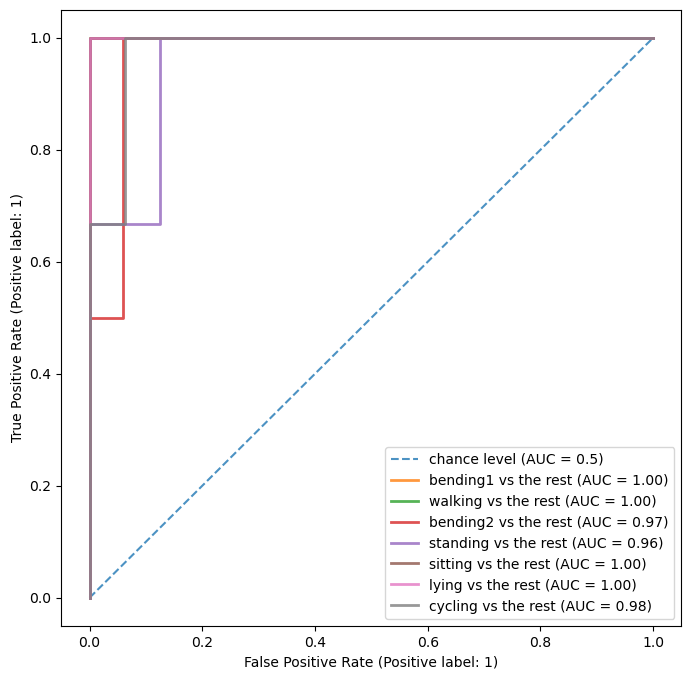

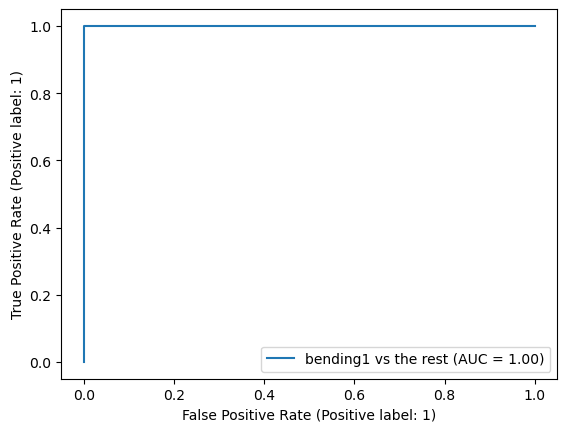

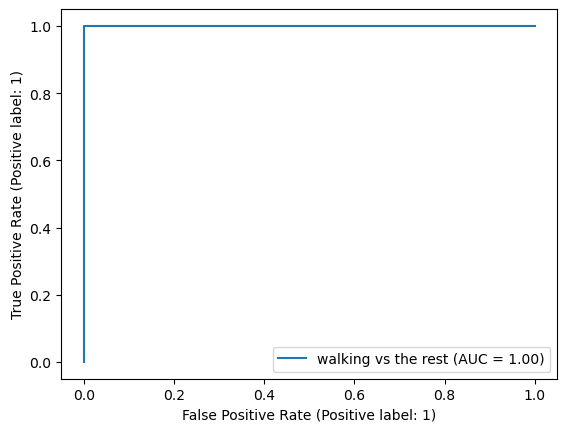

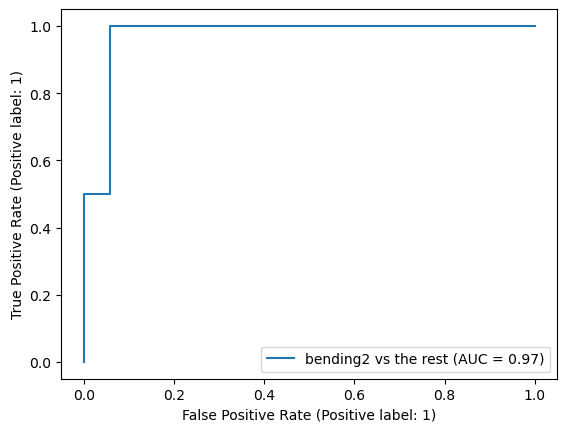

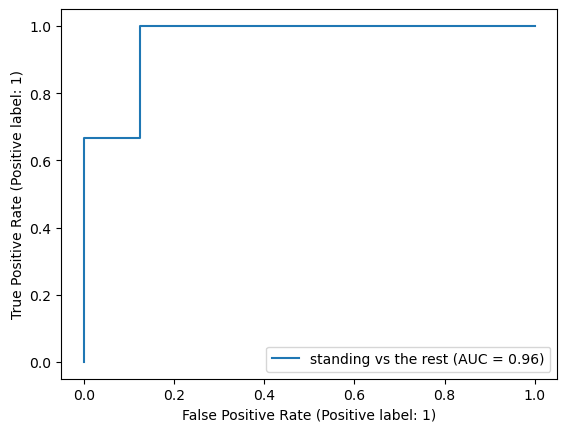

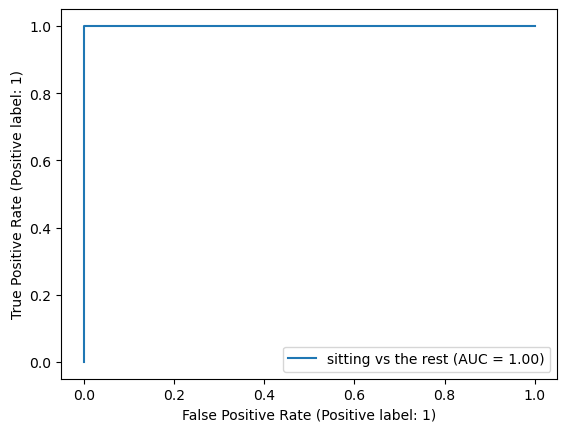

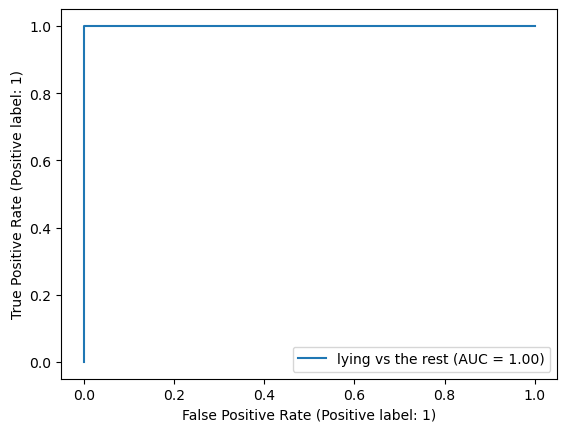

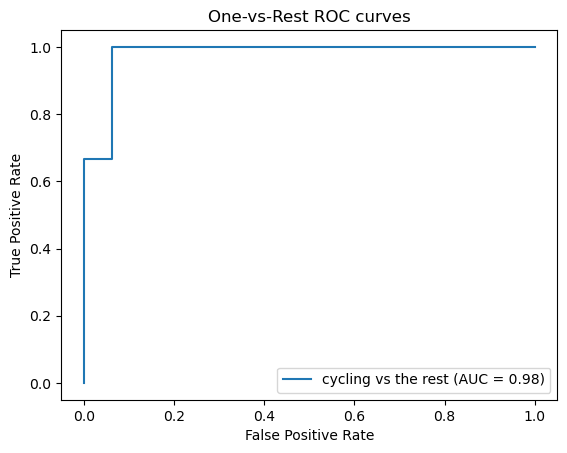

In [20]:
label_binarizer = preprocessing.LabelBinarizer().fit(YTest)
y_onehot_test = label_binarizer.transform(YTest)

fig, ax = plt.subplots(figsize = (8, 8))
ax.plot([0, 1], [0, 1], linestyle = '--', label = 'chance level (AUC = 0.5)', alpha = .8)

for i in YTest.label.unique():
    class_of_interest = i
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    roc_display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        YTestPredProb[:, class_id],
        name = f'{class_of_interest} vs the rest',
        alpha = .8,
        lw = 2,
        ax = ax
    )
    roc_display.plot()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC curves')
plt.legend()
plt.show()

#### ii. Naive Bayes
Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [21]:
#Guassian
trainDataLabels = [file.split(os.path.sep)[3] for file in traindata]
testDataLabels = [file.split(os.path.sep)[3] for file in testdata]

resultGaussianNBDict = {}
for l in tqdm(range (1, 21)):
    dfFeatureSelect = getLSplitFeature(l)
    
    dfFeatureSelectTrain = dfFeatureSelect.iloc[0:69, ]
    YTrain = pd.DataFrame({"label": trainDataLabels})
    dfFeatureSelectTest = dfFeatureSelect. iloc [69:, ]
    Test = pd.DataFrame({"label": testDataLabels})

    dfFeatureSelectTrain.reset_index(drop = True, inplace = True) 
    dfFeatureSelectTest.reset_index(drop = True, inplace = True)
    YTrain.reset_index(drop = True, inplace = True)
    YTest.reset_index(drop = True, inplace = True)

    modelNB = GaussianNB()

    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

    #evaluate the model and collect the scores
    n_scores = cross_val_score(modelNB, dfFeatureSelectTrain, YTrain.values.ravel(), scoring = 'accuracy', cv = cv, n_jobs = -1)
    meanOfScore = np.mean(n_scores)
    print('1: {} Accuracy: {:%}'.format(l, meanOfScore))
    
    resultGaussianNBDict[l] = meanOfScore
    
maxAcc = 0
bestk = None
for k, v in resultGaussianNBDict.items():
    if v > maxAcc:
        maxAcc = v
        bestk = k
print('==========')
print("GaussianNB best l: {}, best accuracy:{:%}".format(bestk, maxAcc))

  5%|██▏                                         | 1/20 [00:00<00:08,  2.16it/s]

1: 1 Accuracy: 85.018315%


 10%|████▍                                       | 2/20 [00:01<00:12,  1.47it/s]

1: 2 Accuracy: 81.611722%


 15%|██████▌                                     | 3/20 [00:02<00:15,  1.10it/s]

1: 3 Accuracy: 69.560440%


 20%|████████▊                                   | 4/20 [00:03<00:18,  1.15s/it]

1: 4 Accuracy: 67.216117%


 25%|███████████                                 | 5/20 [00:05<00:21,  1.41s/it]

1: 5 Accuracy: 68.534799%


 30%|█████████████▏                              | 6/20 [00:08<00:23,  1.68s/it]

1: 6 Accuracy: 67.545788%


 35%|███████████████▍                            | 7/20 [00:10<00:25,  1.96s/it]

1: 7 Accuracy: 66.520147%


 40%|█████████████████▌                          | 8/20 [00:13<00:27,  2.27s/it]

1: 8 Accuracy: 68.058608%


 45%|███████████████████▊                        | 9/20 [00:16<00:28,  2.58s/it]

1: 9 Accuracy: 61.831502%


 50%|█████████████████████▌                     | 10/20 [00:20<00:29,  2.90s/it]

1: 10 Accuracy: 63.699634%


 55%|███████████████████████▋                   | 11/20 [00:24<00:29,  3.24s/it]

1: 11 Accuracy: 62.893773%


 60%|█████████████████████████▊                 | 12/20 [00:28<00:28,  3.57s/it]

1: 12 Accuracy: 59.853480%


 65%|███████████████████████████▉               | 13/20 [00:33<00:27,  3.91s/it]

1: 13 Accuracy: 57.912088%


 70%|██████████████████████████████             | 14/20 [00:38<00:25,  4.25s/it]

1: 14 Accuracy: 61.355311%


 75%|████████████████████████████████▎          | 15/20 [00:43<00:22,  4.58s/it]

1: 15 Accuracy: 57.985348%


 80%|██████████████████████████████████▍        | 16/20 [00:49<00:19,  4.94s/it]

1: 16 Accuracy: 54.981685%


 85%|████████████████████████████████████▌      | 17/20 [00:55<00:15,  5.27s/it]

1: 17 Accuracy: 54.542125%


 90%|██████████████████████████████████████▋    | 18/20 [01:02<00:11,  5.62s/it]

1: 18 Accuracy: 54.102564%


 95%|████████████████████████████████████████▊  | 19/20 [01:08<00:05,  5.98s/it]

1: 19 Accuracy: 53.626374%


100%|███████████████████████████████████████████| 20/20 [01:16<00:00,  3.80s/it]

1: 20 Accuracy: 52.637363%
GaussianNB best l: 1, best accuracy:85.018315%


In [22]:
modelNB = GaussianNB()
modelNB.fit(dfFeatureSelectTrain, YTrain)
YTestPred = modelNB.predict(dfFeatureSelectTest)
YTestPredProb = modelNB.predict_proba(dfFeatureSelectTest)

print(confusion_matrix(YTest, YTestPred))
print(classification_report(YTest, YTestPred))
print("GaussianNB Test Error: {:%}".format(1 - accuracy_score(YTest, YTestPred)))

[[0 0 0 2 0 0 0]
 [0 0 0 0 0 2 0]
 [0 0 3 0 0 0 0]
 [0 0 1 2 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 1 0 2 0 0]
 [0 0 0 0 0 0 3]]
              precision    recall  f1-score   support

    bending1       0.00      0.00      0.00         2
    bending2       0.00      0.00      0.00         2
     cycling       0.60      1.00      0.75         3
       lying       0.50      0.67      0.57         3
     sitting       0.60      1.00      0.75         3
    standing       0.00      0.00      0.00         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.58        19
   macro avg       0.39      0.52      0.44        19
weighted avg       0.43      0.58      0.48        19

GaussianNB Test Error: 42.105263%


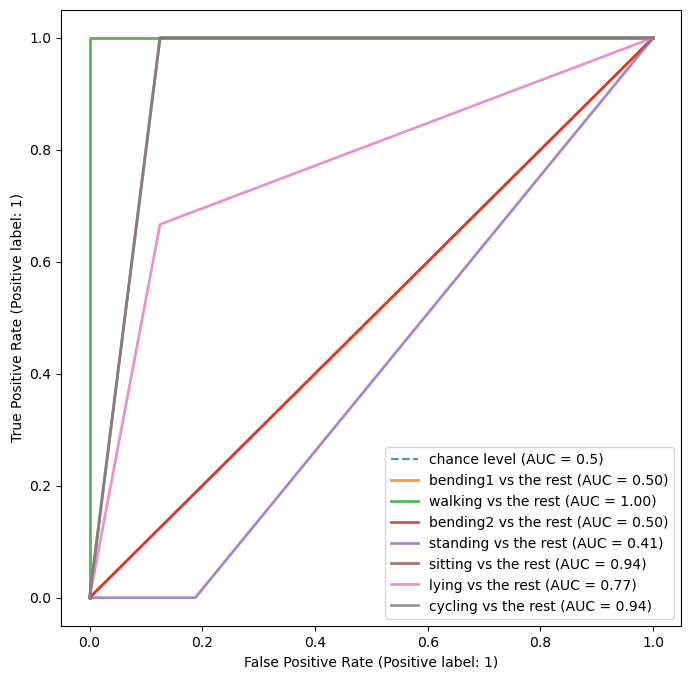

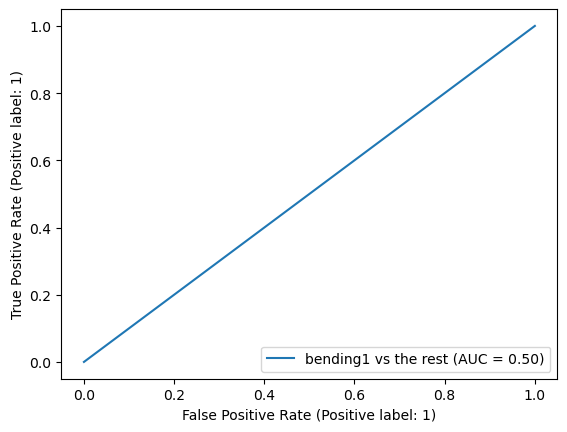

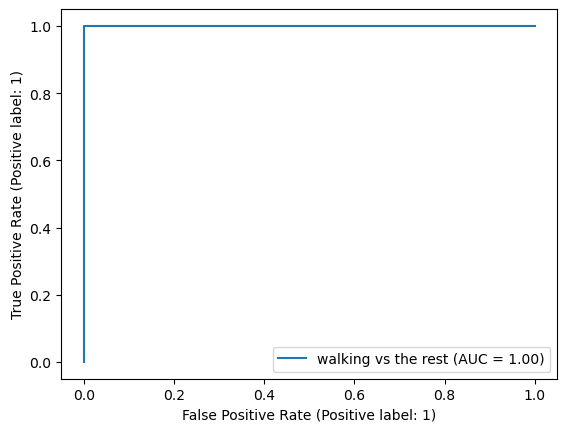

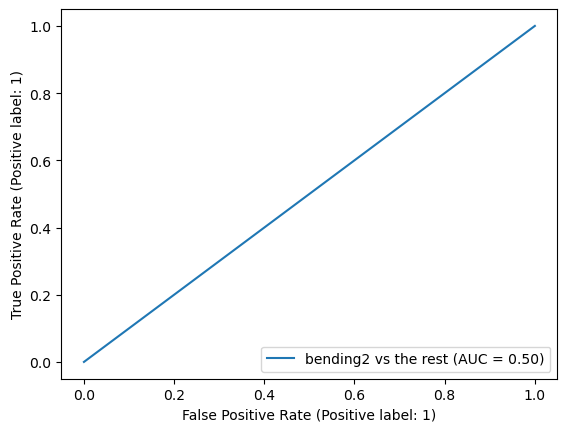

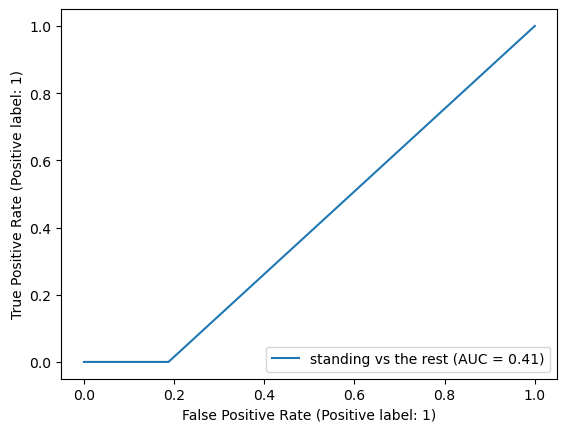

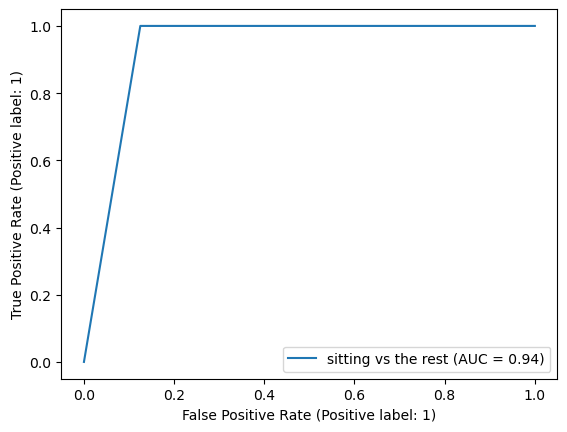

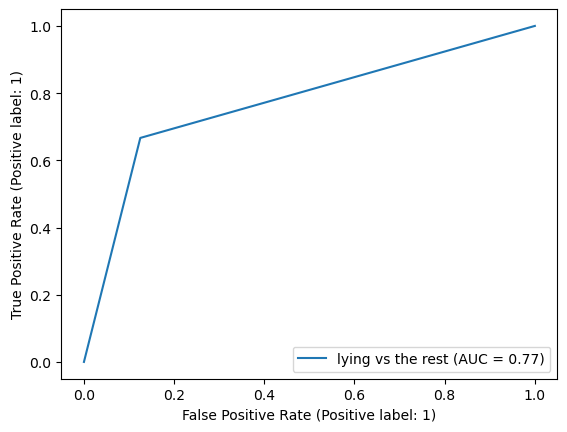

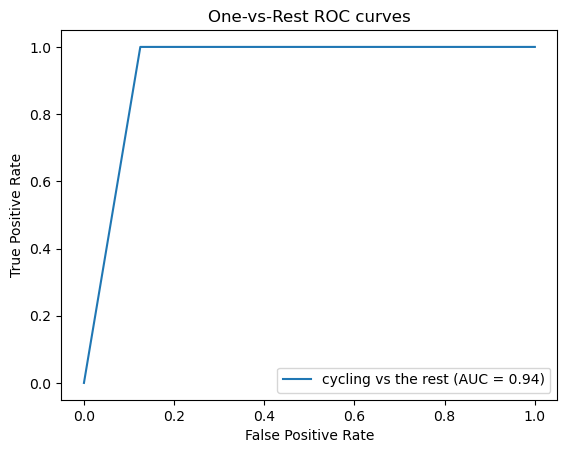

In [23]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot([0, 1], [0, 1], linestyle = '--', label = 'chance level (AUC = 0.5)', alpha = .8)

for i in YTest.label.unique():
    class_of_interest = i
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    roc_display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        YTestPredProb[:, class_id],
        name = f'{class_of_interest} vs the rest',
        alpha = .8,
        lw = 2,
        ax = ax
    )
    roc_display.plot()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC curves')
plt.legend()
plt.show()

In [24]:
#Multinomial
resultMultinomialNBDict = {}
for l in tqdm(range (1, 21)):
    dfFeatureSelect = getLSplitFeature (l)
    
    dfFeatureSelectTrain = dfFeatureSelect.iloc [0:69, ]
    YTrain = pd.DataFrame({"label": trainDataLabels})
    dfFeatureSelectTest = dfFeatureSelect.iloc[69:, ]
    YTest = pd.DataFrame({"label": testDataLabels})
    
    dfFeatureSelectTrain.reset_index(drop = True, inplace = True) 
    dfFeatureSelectTest.reset_index(drop = True, inplace = True)
    YTrain.reset_index(drop = True, inplace = True)
    YTest.reset_index(drop = True, inplace = True)
    
    modelNB = MultinomialNB()
    
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
    
    #evaluate the model and collect the scores
    n_scores = cross_val_score(modelNB, dfFeatureSelectTrain, YTrain.values.ravel(), scoring = 'accuracy', cv = cv, n_jobs = -1)
    meanOfScore = np.mean(n_scores)
    print('l: {} Accuracy: {:%}'.format(l, meanOfScore))
    resultMultinomialNBDict[l] = meanOfScore
    
maxAcc = 0
bestk = None
for k, v in resultMultinomialNBDict.items():
    if v > maxAcc:
        maxAcc = v
        bestk = k
print('==========')        
print ("MultinomialNB best 1: {}, best accuracy: {:%}".format(bestk, maxAcc))

  5%|██▏                                         | 1/20 [00:00<00:08,  2.22it/s]

l: 1 Accuracy: 83.003663%


 10%|████▍                                       | 2/20 [00:01<00:11,  1.51it/s]

l: 2 Accuracy: 78.241758%


 15%|██████▌                                     | 3/20 [00:02<00:15,  1.12it/s]

l: 3 Accuracy: 80.659341%


 20%|████████▊                                   | 4/20 [00:03<00:18,  1.13s/it]

l: 4 Accuracy: 79.780220%


 25%|███████████                                 | 5/20 [00:05<00:21,  1.41s/it]

l: 5 Accuracy: 83.113553%


 30%|█████████████▏                              | 6/20 [00:08<00:23,  1.68s/it]

l: 6 Accuracy: 81.208791%


 35%|███████████████▍                            | 7/20 [00:10<00:25,  1.98s/it]

l: 7 Accuracy: 80.293040%


 40%|█████████████████▌                          | 8/20 [00:13<00:27,  2.27s/it]

l: 8 Accuracy: 81.172161%


 45%|███████████████████▊                        | 9/20 [00:16<00:28,  2.58s/it]

l: 9 Accuracy: 80.695971%


 50%|█████████████████████▌                     | 10/20 [00:20<00:28,  2.90s/it]

l: 10 Accuracy: 80.256410%


 55%|███████████████████████▋                   | 11/20 [00:24<00:29,  3.23s/it]

l: 11 Accuracy: 78.241758%


 60%|█████████████████████████▊                 | 12/20 [00:28<00:28,  3.56s/it]

l: 12 Accuracy: 78.754579%


 65%|███████████████████████████▉               | 13/20 [00:33<00:27,  3.90s/it]

l: 13 Accuracy: 79.743590%


 70%|██████████████████████████████             | 14/20 [00:38<00:25,  4.25s/it]

l: 14 Accuracy: 77.765568%


 75%|████████████████████████████████▎          | 15/20 [00:43<00:23,  4.60s/it]

l: 15 Accuracy: 77.765568%


 80%|██████████████████████████████████▍        | 16/20 [00:49<00:19,  4.93s/it]

l: 16 Accuracy: 78.278388%


 85%|████████████████████████████████████▌      | 17/20 [00:55<00:15,  5.28s/it]

l: 17 Accuracy: 79.706960%


 90%|██████████████████████████████████████▋    | 18/20 [01:02<00:11,  5.62s/it]

l: 18 Accuracy: 77.252747%


 95%|████████████████████████████████████████▊  | 19/20 [01:08<00:05,  5.98s/it]

l: 19 Accuracy: 76.300366%


100%|███████████████████████████████████████████| 20/20 [01:15<00:00,  3.80s/it]

l: 20 Accuracy: 77.326007%
MultinomialNB best 1: 5, best accuracy: 83.113553%


In [25]:
modelNB = MultinomialNB()
modelNB.fit(dfFeatureSelectTrain, YTrain)
YTestPred = modelNB.predict(dfFeatureSelectTest)
YTestPredProb = modelNB.predict_proba(dfFeatureSelectTest)

print(confusion_matrix(YTest, YTestPred))
print(classification_report(YTest, YTestPred))
print("MultinomiaUNB Test Error: {:%}".format(1 - accuracy_score(YTest, YTestPred)))

[[2 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
              precision    recall  f1-score   support

    bending1       0.50      1.00      0.67         2
    bending2       0.00      0.00      0.00         2
     cycling       1.00      1.00      1.00         3
       lying       1.00      1.00      1.00         3
     sitting       1.00      0.67      0.80         3
    standing       0.75      1.00      0.86         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.84        19
   macro avg       0.75      0.81      0.76        19
weighted avg       0.80      0.84      0.81        19

MultinomiaUNB Test Error: 15.789474%


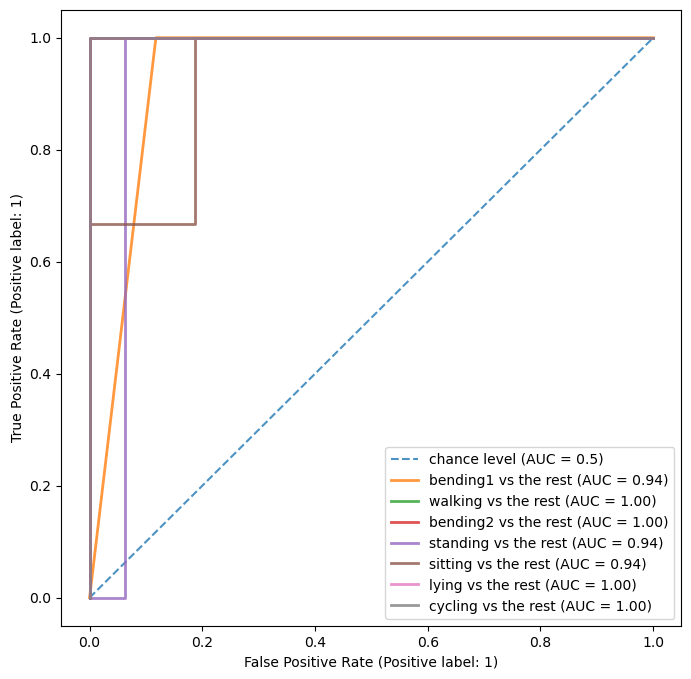

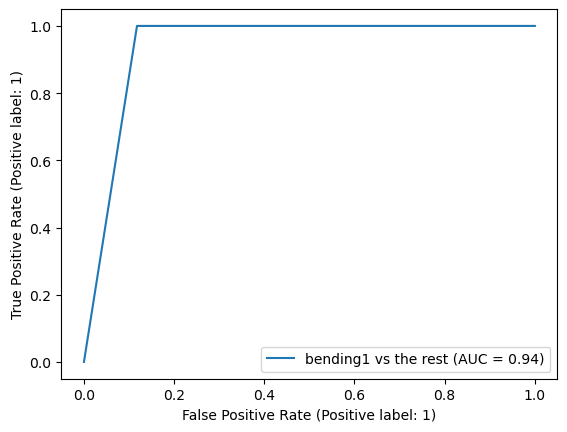

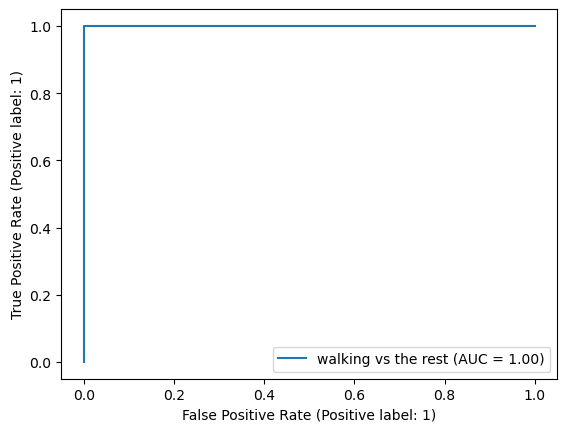

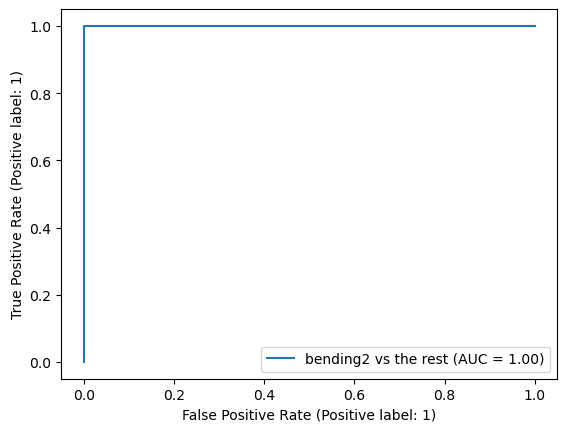

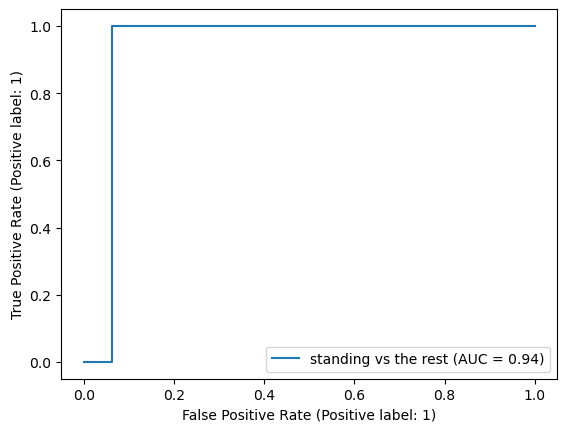

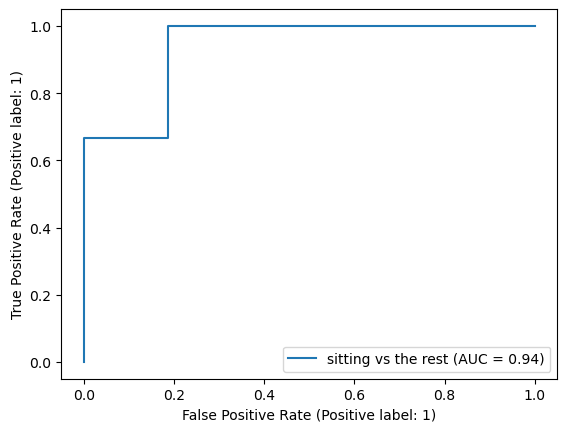

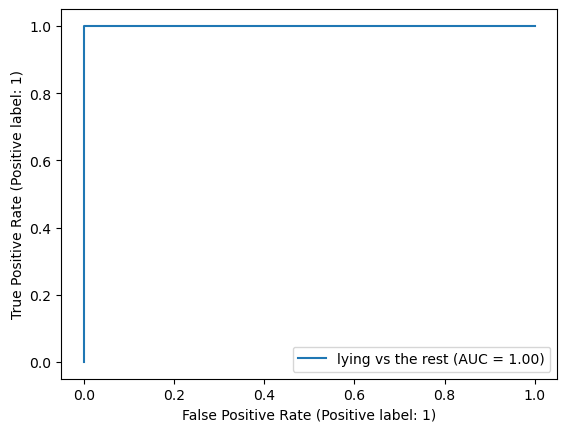

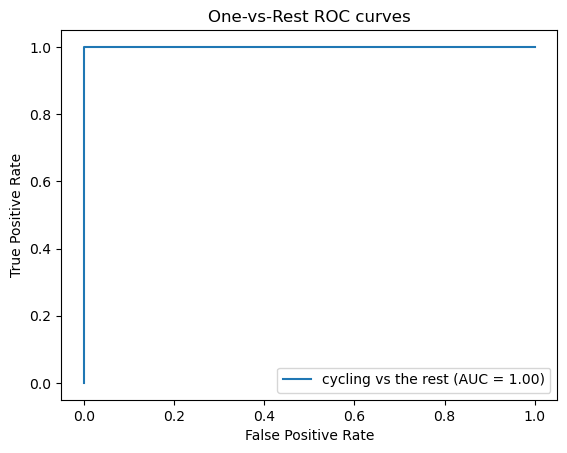

In [26]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot([0, 1], [0, 1], linestyle = '--', label = 'chance level (AUC = 0.5)', alpha = .8)

for i in YTest.label.unique():
    class_of_interest = i
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    roc_display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        YTestPredProb[:, class_id],
        name = f'{class_of_interest} vs the rest',
        alpha = .8,
        lw = 2,
        ax = ax
    )
    roc_display.plot()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC curves')
plt.legend()
plt.show()

#### ii. Comparison
Which method is better for multi-class classification in this problem?

The Multinomial yields a better result than the Gaussian.

## 3. ISLR 4.8.3
This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class-specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.

Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.

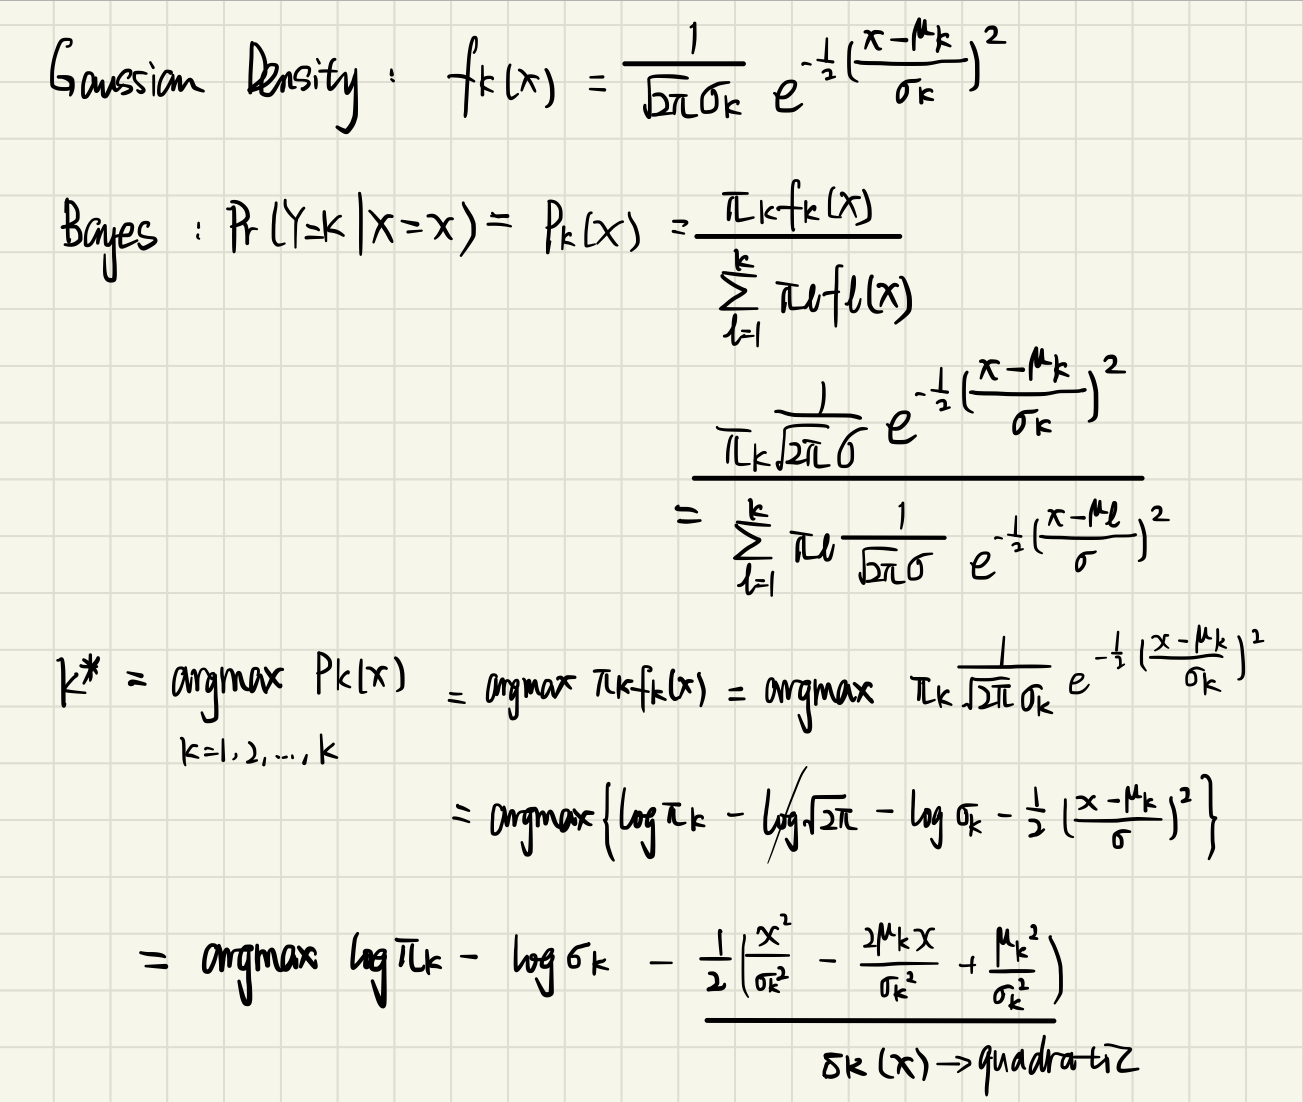

## 4. ISLR 4.8.7
Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X ̄ = 10, while the mean for those that didn’t was X ̄ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.

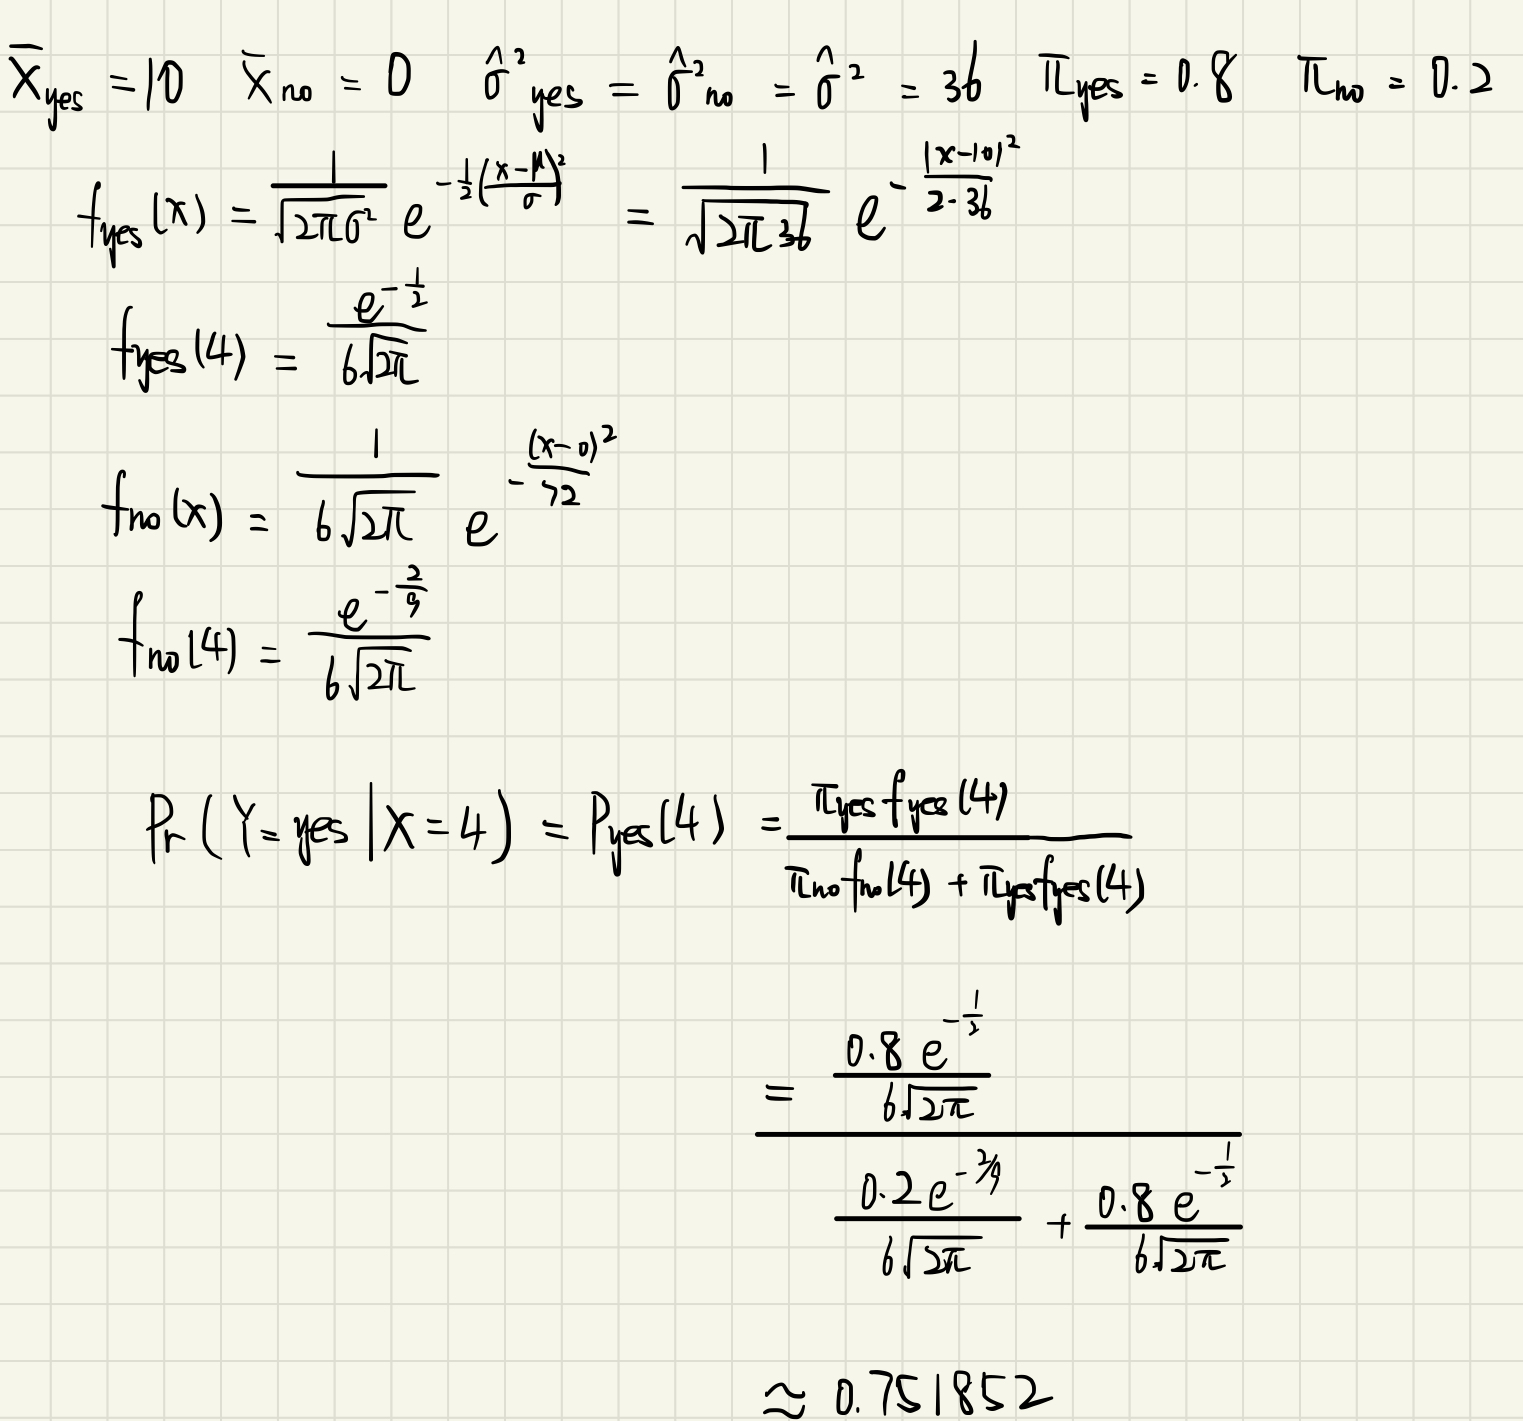